In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
import sys

sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/")
sys.path.append("/home/cctrotte/krauthammer/eustar_clean/benchmark_VAE/src/")
import os
import pickle
from pythae.models import AutoModel
from pythae.ssc.plots import *
import random
import matplotlib.pyplot as plt
import numpy as np
from pythae.ssc.results import EvalPatient, EvaluationDataset
from pythae.ssc.utils import load_cv, remove_short_samples

In [2]:
# adapt paths
data_path = "/home/cctrotte/krauthammer/eustar_clean/fake_data/processed/"
figure_path = "/home/cctrotte/krauthammer/eustar_clean/demo_notebooks/plots/"
model_path = "/home/cctrotte/krauthammer/eustar_clean/demo_notebooks/saved_models/model_fold_0/"

name = "_ml4h"
with open(data_path + "bodies_" + name + ".pkl", "rb") as file:
    bodies = pickle.load(file)
with open(data_path + "cohorts_" + name + ".pkl", "rb") as file:
    cohorts = pickle.load(file)

In [3]:
# variables info
var_weights0 = [
    var.class_weight_norm for var in (bodies[0].variables + bodies[0].labels)
]
(
    data_train_folds,
    data_valid_folds,
    data_test_folds,
    varNames,
    varSplits,
    xyt0,
    xyt1,
) = load_cv(data_path, n_folds = 2, name=name)
var_names0 = [var.name for var in (bodies[0].variables + bodies[0].labels)]

names_x0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "x"]
names_y0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "y"]
names_s0 = [vN for i, vN in enumerate(var_names0) if xyt0[i] == "s"]

kinds_x0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_x0
    if var.name == nx
]
kinds_y0 = [
    var.kind
    for var in (bodies[0].variables + bodies[0].labels)
    for nx in names_y0
    if var.name == nx
]
splits_x0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "x"]
splits_y0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "y"]
splits_s0 = [vN for i, vN in enumerate(varSplits) if xyt0[i] == "s"]

names_x1 = [vN for i, vN in enumerate(varNames) if xyt1[i] == "x"]
kinds_x1 = [item for i, spl in enumerate(splits_x0) for item in [kinds_x0[i]] * spl]

In [4]:
# remove samples of length 0 or 1
for i, (data_train, data_valid, data_test) in enumerate(
    zip(data_train_folds, data_valid_folds, data_test_folds)
):
    data_train, data_valid, data_test = remove_short_samples(
        data_train, data_valid, data_test
    )

    data_train_folds[i] = data_train
    data_valid_folds[i] = data_valid
    data_test_folds[i] = data_test

In [5]:
last_training = sorted(os.listdir(model_path))[-1]
model = AutoModel.load_from_folder(os.path.join(model_path, last_training, 'final_model'))

In [6]:
# move to cpu
model.cpu()
model.device = "cpu"
model.classifiers = [classif.cpu() for classif in model.classifiers]
model.encoder.device = "cpu"
model.decoder.device = "cpu"
fold = 0
data_train = data_train_folds[fold]
data_valid = data_valid_folds[fold]
data_test = data_test_folds[fold]
body = bodies[fold]

In [7]:
from openTSNE import TSNE

In [8]:
tsne = TSNE(
    perplexity=70,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [9]:
evaluation = EvaluationDataset(
    data_test,
    model,
    body,
    splits_x0,
    names_x0,
    kinds_x0,
    splits_y0,
    names_y0,
    kinds_y0,
    names_s0,
    kinds_x1,
    names_x1,
    len(data_test),
)
evaluation.evaluate(num_samples=10)

In [10]:
# fit on train
sample_batch_train = data_train.get_ith_sample_batch_with_customDataLoader(0, 1400)
out_train = model(sample_batch_train)

In [11]:
splits_train = sample_batch_train["splits"]
indices_recon_train = torch.cat(
    [
        torch.cat(
            [
                torch.cat(
                    [
                        torch.full((index, 1), True),
                        torch.full((splits_train[pat] - index, 1), False),
                    ],
                    dim=0,
                )
                for index in range(0, splits_train[pat] + 1)
            ]
        )
        for pat in range(len(splits_train))
    ]
).flatten()
# fit only on reconstruction indices
z_tsne_train = tsne.fit(out_train.z[indices_recon_train].detach())

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, perplexity=70, random_state=42,
     verbose=True)
--------------------------------------------------------------------------------
===> Finding 210 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 5.99 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.55 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.11 seconds
===> Running optimization with exaggeration=12.00, lr=2634.42 for 250 iterations...
Iteration   50, KL divergence 5.5011, 50 iterations in 1.4848 sec
Iteration  100, KL divergence 5.4905, 50 iterations in 1.2229 sec
Iteration  150, KL divergence 5.4902, 50 iterations in 1.3525 sec
Iteration  200, KL divergence 5.4902, 50 iterations in 1.2755 sec
Iteration  250, KL divergence 5.4902, 50 iterations in 1.3296 sec
   --> Time elapsed: 6.67 seconds
===> Running optimizatio

In [12]:
z_tsne_test = z_tsne_train.transform(
    evaluation.predictions.z[evaluation.indices_recon].detach()
)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 6.59 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 173464.0794, 50 iterations in 0.1858 sec
Iteration  100, KL divergence 172159.5964, 50 iterations in 0.1944 sec
Iteration  150, KL divergence 171311.6359, 50 iterations in 0.1897 sec
Iteration  200, KL divergence 170722.8219, 50 iterations in 0.1905 sec
Iteration  250, KL divergence 170265.0547, 50 iterations in 0.1981 sec
   --> Time elapsed: 0.96 seconds


In [13]:
list_of_arrays_recon = np.split(
    evaluation.non_missing_y_recon[evaluation.indices_recon],
    np.cumsum(evaluation.splits_y0[:-1]),
    axis=1,
)

### Latent space t-SNE overlaid with predicted concepts

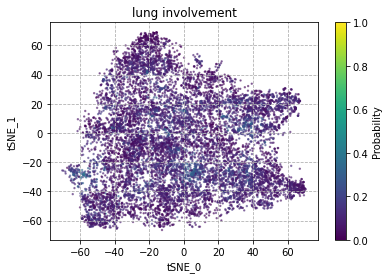

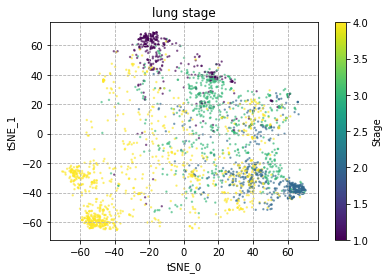

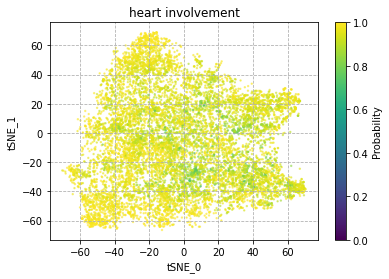

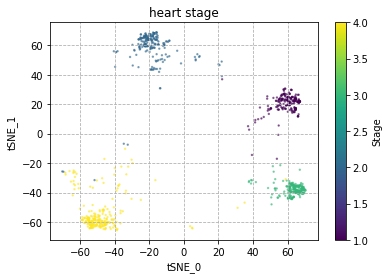

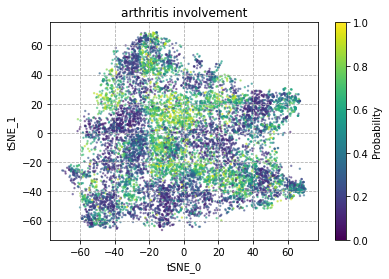

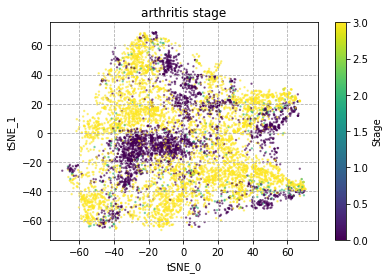

In [14]:
import matplotlib.cm as cm

titles = {
    0: "lung involvement",
    1: "lung stage",
    2: "heart involvement",
    3: "heart stage",
    4: "arthritis involvement",
    5: "arthritis stage",
}

for label_index, title in enumerate(titles.values()):
    fig, ax = plt.subplots()
    indices = list_of_arrays_recon[label_index].all(axis=1)

    if title in ["lung involvement", "heart involvement", "arthritis involvement"]:
        overlay_color = evaluation.res_list_y[label_index][1].detach()
        colorbar_vmin = 0
        colorbar_vmax = 1
        color = overlay_color[evaluation.indices_recon][indices]
        name_cbar = "Probability"
    else:
        overlay_color = evaluation.predicted_cats_y
        colorbar_vmin = np.nanmin(
            np.array(overlay_color[evaluation.indices_recon][indices, label_index])
        )
        colorbar_vmax = np.nanmax(
            np.array(overlay_color[evaluation.indices_recon][indices, label_index])
        )
        color = overlay_color[evaluation.indices_recon][indices, label_index]
        name_cbar = "Stage"

    scatter = ax.scatter(
        z_tsne_test[indices, 0],
        z_tsne_test[indices, 1],
        c=color,
        alpha=0.5,
        vmin=colorbar_vmin,
        vmax=colorbar_vmax,
        s=2,
    )

    plt.title(titles[label_index])

    # Create a ScalarMappable object for the colorbar
    sm = cm.ScalarMappable(
        cmap=scatter.get_cmap(),
        norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
    )
    sm.set_array([])  # Set an empty array to ensure correct color mapping

    # Add colorbar
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel(name_cbar)
    ax.set_xlabel("tSNE_0")
    ax.set_ylabel("tSNE_1")
    ax.grid(linestyle="--")

    plt.show()

### Latent space t-SNE overlaid with ground truth labels

lung involvement


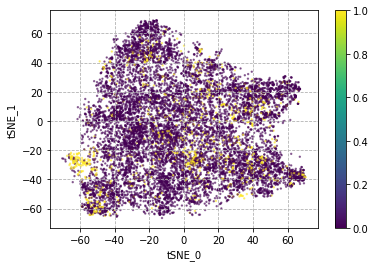

lung stage


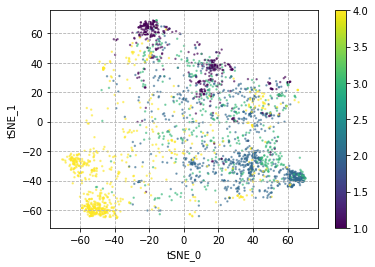

heart involvement


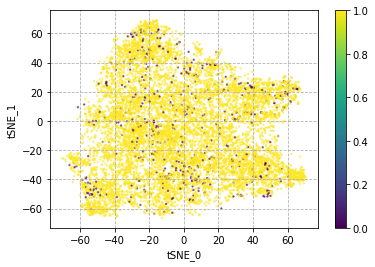

heart stage


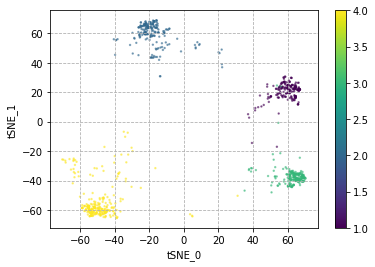

arthritis involvement


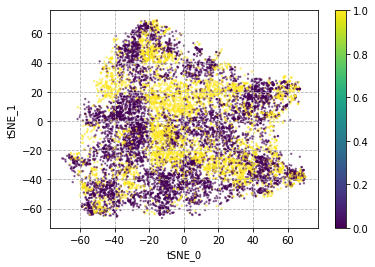

arthritis stage


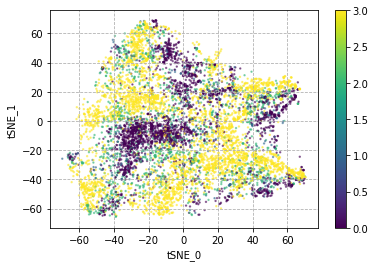

In [15]:
for label_index in range(len(titles)):
    fig, ax = plt.subplots()
    overlay_color = evaluation.ground_truth_y[0]
    indices = list_of_arrays_recon[label_index].all(axis=1)
    print(titles[label_index])
    # label_index = 4
    colorbar_vmin = np.nanmin(
        np.array(overlay_color[evaluation.indices_recon][indices, label_index])
    )
    colorbar_vmax = np.nanmax(
        np.array(overlay_color[evaluation.indices_recon, label_index])
    )
    scatter = ax.scatter(
        z_tsne_test[indices, 0],
        z_tsne_test[indices, 1],
        c=overlay_color[evaluation.indices_recon][indices, label_index],
        alpha=0.5,
        vmin=colorbar_vmin,
        vmax=colorbar_vmax,
        s=2,
    )
    # plt.title(titles[label_index])

    # Create a ScalarMappable object for the colorbar
    sm = cm.ScalarMappable(
        cmap=scatter.get_cmap(),
        norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
    )
    sm.set_array([])  # Set an empty array to ensure correct color mapping

    # Add colorbar
    cbar = plt.colorbar(sm)
    ax.set_xlabel("tSNE_0")
    ax.set_ylabel("tSNE_1")
    ax.grid(linestyle="--")

    plt.show()

### Patient trajectory in latent space

In [16]:
z_grouped = torch.split(
    evaluation.predictions.z, [elem * (elem + 1) for elem in evaluation.splits]
)
z_grouped = [
    torch.split(elem, [evaluation.splits[index]] * (evaluation.splits[index] + 1))
    for index, elem in enumerate(z_grouped)
]
z_grouped_samp = [
    torch.split(
        evaluation.samples[i].z, [elem * (elem + 1) for elem in evaluation.splits]
    )
    for i in range(len(evaluation.samples))
]
z_grouped_samp = [
    [
        torch.split(elem, [evaluation.splits[index]] * (evaluation.splits[index] + 1))
        for index, elem in enumerate(z_grouped_samp[i])
    ]
    for i in range(len(evaluation.samples))
]
true_labels_y2_grouped = torch.split(
    evaluation.ground_truth_y[0], [elem * (elem + 1) for elem in evaluation.splits]
)
true_labels_y2_grouped = [
    torch.split(elem, [evaluation.splits[index]] * (evaluation.splits[index] + 1))
    for index, elem in enumerate(true_labels_y2_grouped)
]
y_out_rec_grouped = torch.split(
    evaluation.predicted_cats_y, [elem * (elem + 1) for elem in evaluation.splits]
)
y_out_rec_grouped = [
    torch.split(elem, [evaluation.splits[index]] * (evaluation.splits[index] + 1))
    for index, elem in enumerate(y_out_rec_grouped)
]

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.06 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 999.9841, 50 iterations in 1.0059 sec
Iteration  100, KL divergence 990.3842, 50 iterations in 1.0057 sec
Iteration  150, KL divergence 983.6727, 50 iterations in 0.8507 sec
Iteration  200, KL divergence 978.2312, 50 iterations in 0.8026 sec
Iteration  250, KL divergence 973.6039, 50 iterations in 0.8003 sec
   --> Time elapsed: 4.47 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.05 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteration  250, KL divergence 1006.6667, 50 iterations in 0.7945 sec
   --> Time elapsed: 4.20 seconds


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


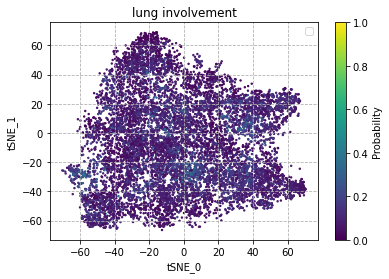

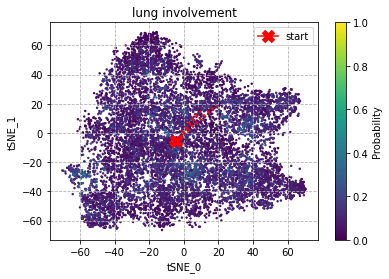

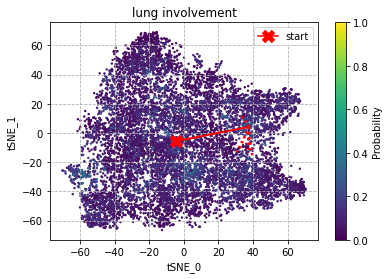

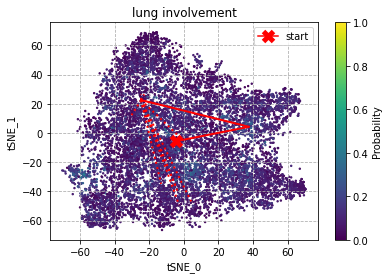

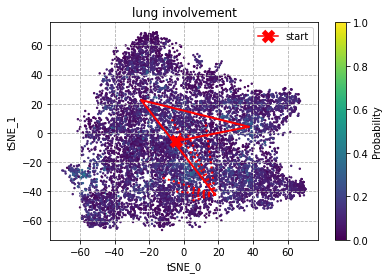

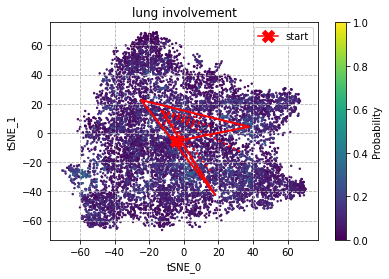

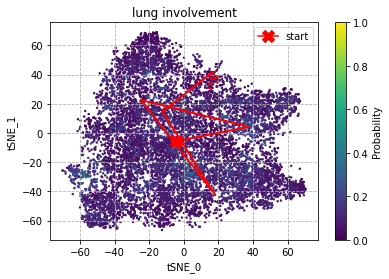

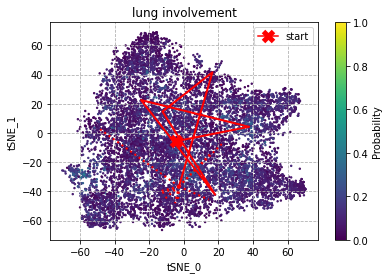

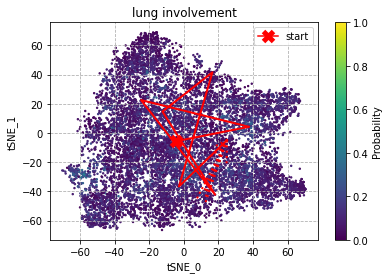

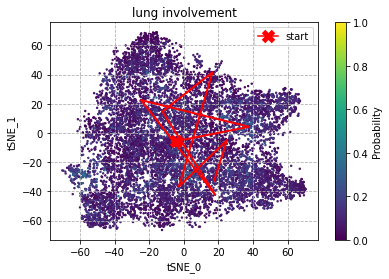

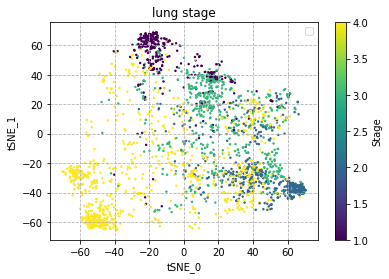

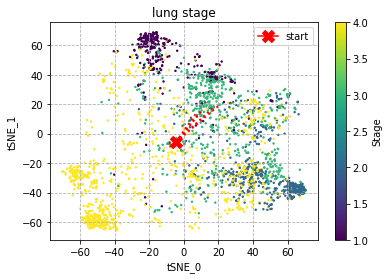

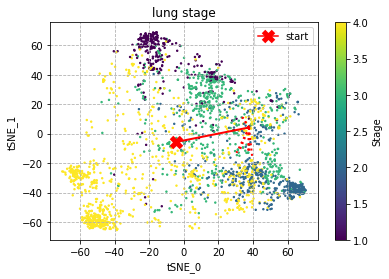

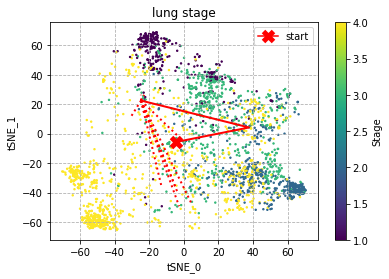

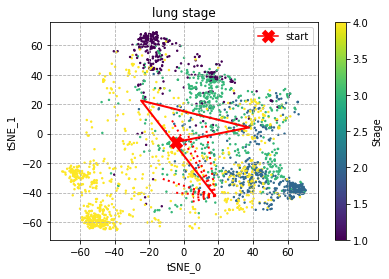

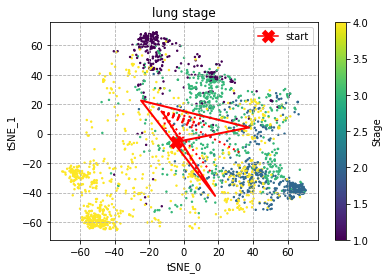

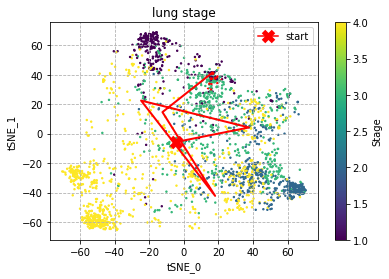

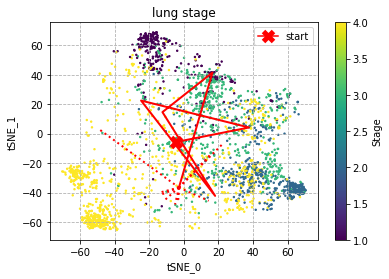

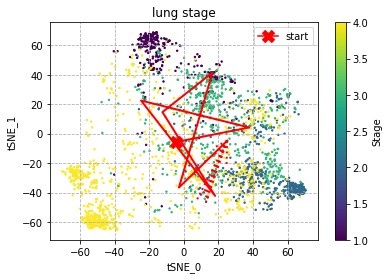

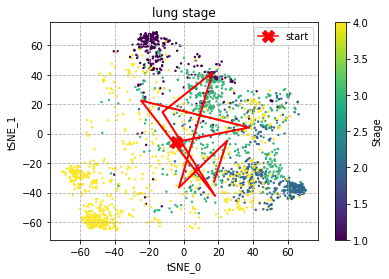

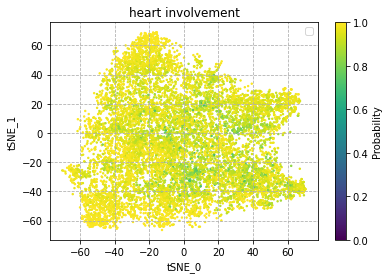

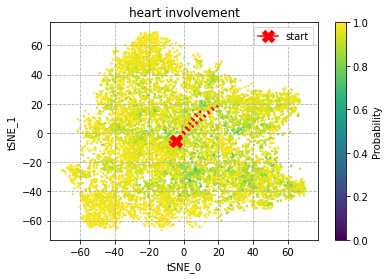

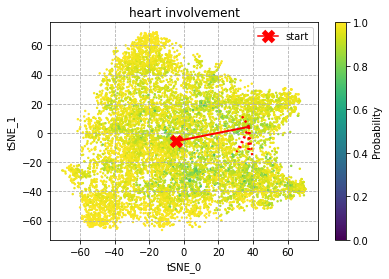

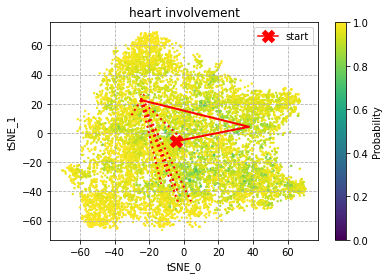

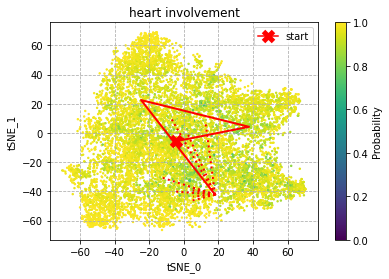

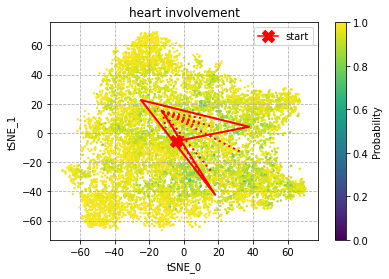

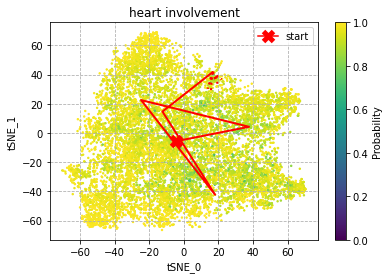

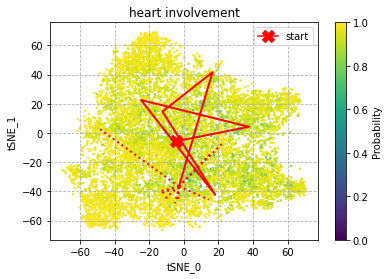

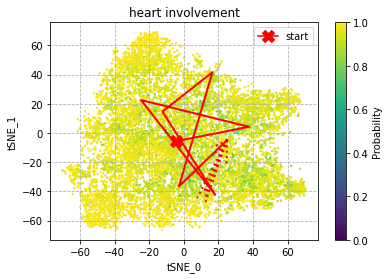

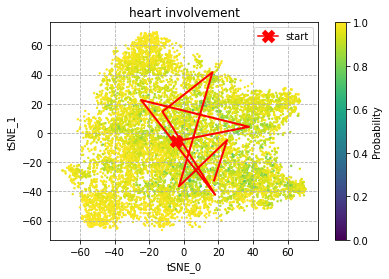

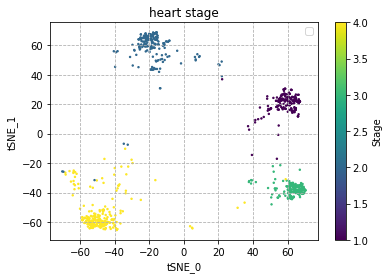

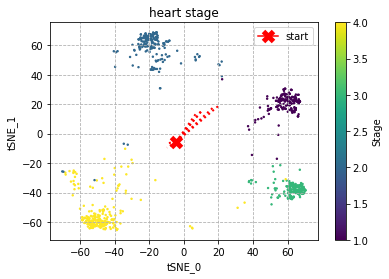

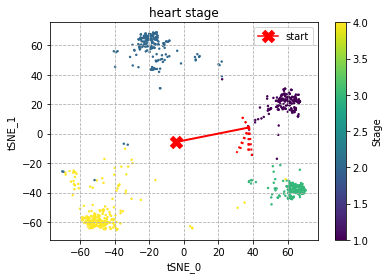

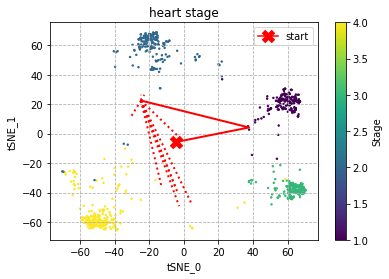

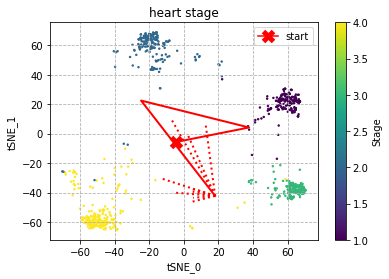

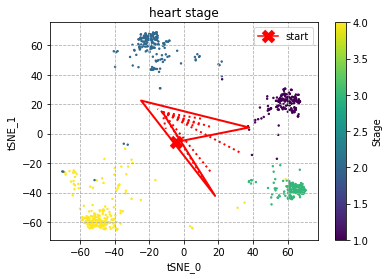

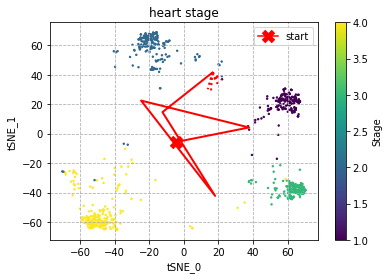

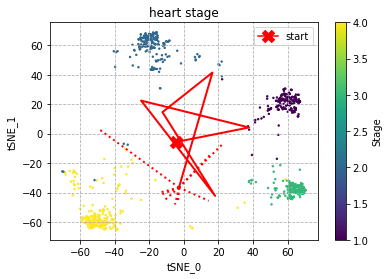

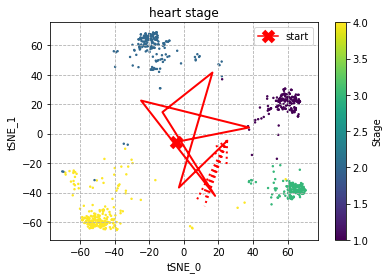

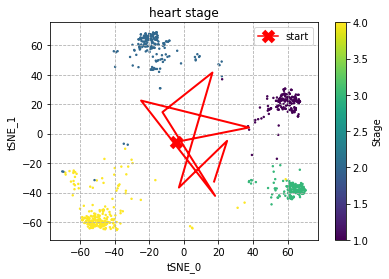

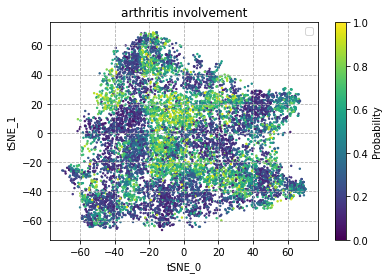

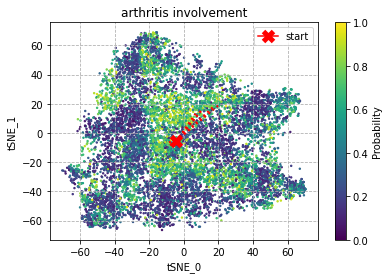

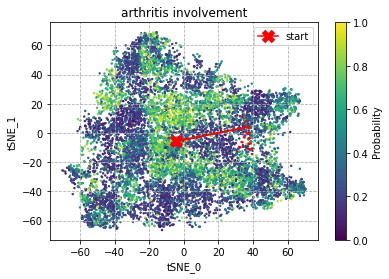

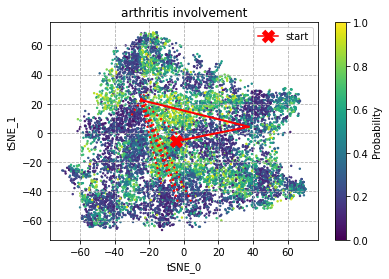

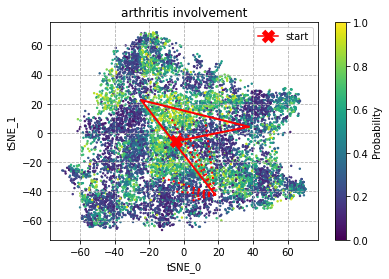

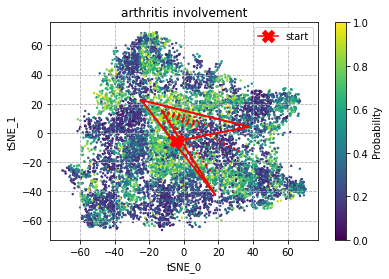

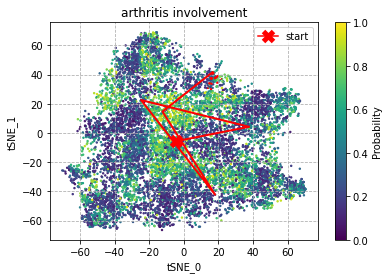

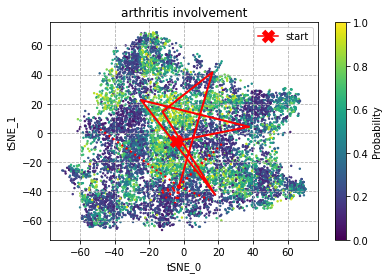

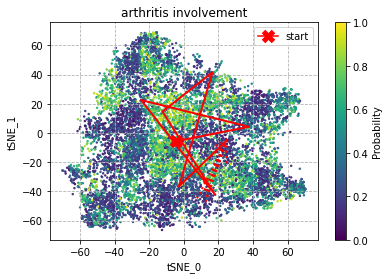

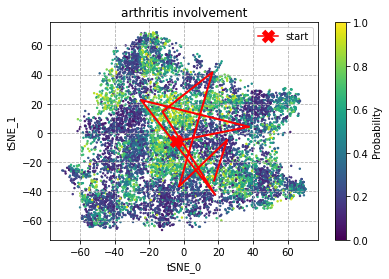

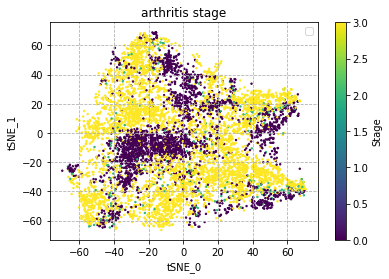

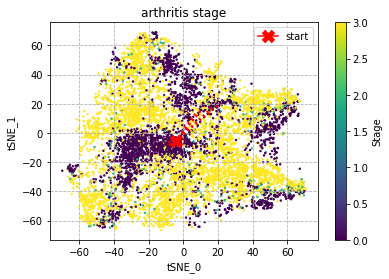

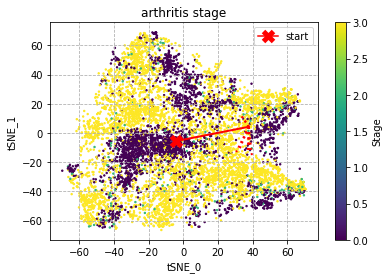

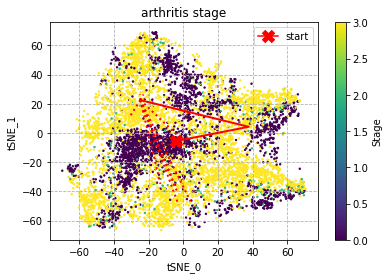

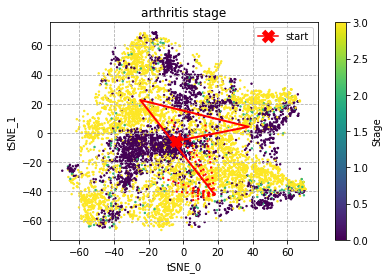

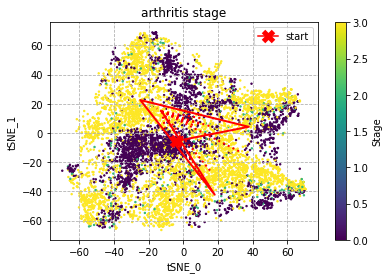

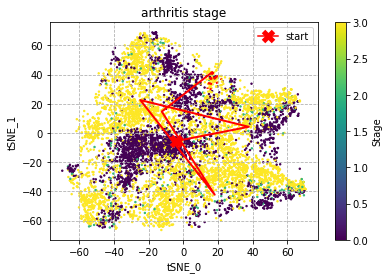

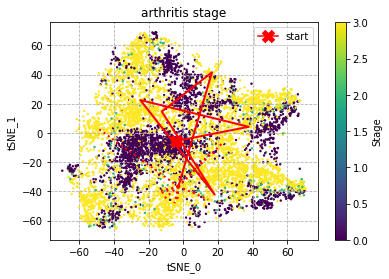

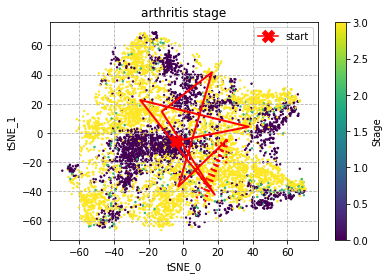

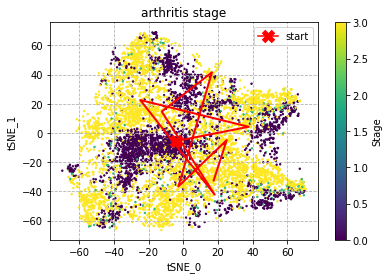

In [17]:
use_ground_truth = False
pat = random.choice(range(len(evaluation.splits)))

z_tsne_pat = torch.split(
    torch.tensor(z_tsne_train.transform(torch.cat(z_grouped[pat])[:, :])),
    evaluation.splits[pat],
)
z_tsne_pat_preds = [
    torch.split(
        torch.tensor(z_tsne_train.transform(torch.cat(z_grouped_samp[i][pat])[:, :])),
        evaluation.splits[pat],
    )
    for i in range(len(evaluation.samples))
]
# color_shades = np.linspace(0.2, 1, len(evaluation.samples))

if use_ground_truth:
    overlay_color = evaluation.ground_truth_y[0]
else:
    overlay_color = evaluation.predicted_cats_y
for label_index, title in enumerate(titles.values()):
    indices = list_of_arrays_recon[label_index].all(axis=1)
    if title in ["lung involvement", "heart involvement", "arthritis involvement"]:
        overlay_color = evaluation.res_list_y[label_index][1].detach()
        colorbar_vmin = 0
        colorbar_vmax = 1
        color = overlay_color[evaluation.indices_recon][indices]
        name_cbar = "Probability"
    else:
        overlay_color = evaluation.predicted_cats_y
        colorbar_vmin = np.nanmin(
            np.array(overlay_color[evaluation.indices_recon][indices, label_index])
        )
        colorbar_vmax = np.nanmax(
            np.array(overlay_color[evaluation.indices_recon][indices, label_index])
        )
        color = overlay_color[evaluation.indices_recon][indices, label_index]
        name_cbar = "Stage"

    non_miss_pat = np.split(
        evaluation.non_missing_y_splitted[pat],
        np.cumsum(evaluation.splits_y0[:-1]),
        axis=1,
    )[label_index].all(axis=1)

    for num_to_rec in range(evaluation.splits[pat] + 1):

        fig, ax = plt.subplots()
        scatter = ax.scatter(
            z_tsne_test[indices, 0],
            z_tsne_test[indices, 1],
            c=color,
            s=2,
            vmin=colorbar_vmin,
            vmax=colorbar_vmax,
        )
        #         to_plot_pat_0 = z_tsne_pat[num_to_rec][:num_to_rec,0][non_miss_pat[:num_to_rec]]
        #         to_plot_pat_1 = z_tsne_pat[num_to_rec][:num_to_rec,1][non_miss_pat[:num_to_rec]]
        to_plot_pat_0 = z_tsne_pat[-1][:num_to_rec, 0]
        to_plot_pat_1 = z_tsne_pat[-1][:num_to_rec, 1]

        ax.plot(to_plot_pat_0, to_plot_pat_1, c="red", linewidth=2)
        if len(to_plot_pat_0) > 0:
            # plt.text(to_plot_pat_0[0] + 5, to_plot_pat_1[0], s = 'start',  color="#570000", fontsize=12, weight = "bold")
            plt.plot(
                to_plot_pat_0[0],
                to_plot_pat_1[0],
                marker="x",
                color="red",
                markersize=10,
                markeredgewidth=5,
                label="start",
            )
        if num_to_rec < evaluation.splits[pat]:
            for i in range(len(evaluation.samples)):
                to_plot_pat_pred_0 = z_tsne_pat_preds[i][num_to_rec][
                    num_to_rec : num_to_rec + 1, 0
                ]
                to_plot_pat_pred_1 = z_tsne_pat_preds[i][num_to_rec][
                    num_to_rec : num_to_rec + 1, 1
                ]
                if len(to_plot_pat_0) > 0 and len(to_plot_pat_pred_0) > 0:
                    ax.plot(
                        torch.stack([to_plot_pat_0[-1], to_plot_pat_pred_0[0]]),
                        torch.stack([to_plot_pat_1[-1], to_plot_pat_pred_1[0]]),
                        c="red",
                        linewidth=2,
                        linestyle=":",
                    )
                ax.plot(
                    to_plot_pat_pred_0,
                    to_plot_pat_pred_1,
                    c="red",
                    linewidth=2,
                    linestyle=":",
                )

        sm = cm.ScalarMappable(
            cmap=scatter.get_cmap(),
            norm=plt.Normalize(vmin=colorbar_vmin, vmax=colorbar_vmax),
        )
        sm.set_array([])  # Set an empty array to ensure correct color mapping

        ax.set_xlabel("tSNE_0")
        ax.set_ylabel("tSNE_1")

        # Add colorbar
        cbar = plt.colorbar(sm)
        cbar.ax.set_ylabel(name_cbar)
        ax.grid(linestyle="--")

        ax.legend()
        # print(titles[label_index])
        plt.title(titles[label_index])